In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### GADGET

In [6]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')

path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'
snap = h5py.File(path+'outputs_1/snap_496.h5py', 'r')

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
    
for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

    pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Velocities'].value

    pgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Coordinates'].value
    mgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Masses'].value
    
    pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'].value
    
    z = a0/aexp[0] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])/h
    ystr = (pstr[:,1]-cm[1])/h
    zstr = (pstr[:,2]-cm[2])/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    xgas = (pgas[:,0]-cm[0])/h
    ygas = (pgas[:,1]-cm[1])/h
    zgas = (pgas[:,2]-cm[2])/h

    xdrk = (pdrk[:,0]-cm[0])/h
    ydrk = (pdrk[:,1]-cm[1])/h
    zdrk = (pdrk[:,2]-cm[2])/h

    v_x = vel[:,0] + Ht *xstr/1000.
    v_y = vel[:,1] + Ht *ystr/1000.
    v_z = vel[:,2] + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr/h
    mgas = mgas/h
    mdrk = mdrk/h

    r200 = r200/h

    rgal=0.15*r200

    limit = np.where(r < rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
    corte,=np.where(r<3.)
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3.)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
    corte1, = np.where(rn < rgal)
#     corte_bin2, = np.where(rn < 6.)
    
    R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)

    nbin = 50 #20
    rbin, nodos = bines2.rbin1(R, nbin)

    Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
    Vz = vzn[corte1]
    Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R
    

    sigma_z = np.zeros(nbin)
    sigma_R = np.zeros(nbin)
    sigma_t = np.zeros(nbin)
    
    
    for j in range(nbin):
        mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
        n = len(mask)
        Vz_mean = np.mean(Vz[mask])
        Vr_mean = np.mean(Vr[mask])
        Vt_mean = np.mean(Vt[mask])
        
        sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
        sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
        sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)

    
    surf_den, rden = den.surf_density(R,mstr[corte1]*1e10,nbin)
    
    xngas = e1x*xgas + e1y*ygas + e1z*zgas
    yngas = e2x*xgas + e2y*ygas + e2z*zgas
    zngas = e3x*xgas + e3y*ygas + e3z*zgas
    rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
    
    xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
    
    corte_gas = np.where(rgas < rgal)
    corte_drk = np.where(rdrk < rgal)
    
    Rgas = np.sqrt(xngas[corte_gas]**2 + yngas[corte_gas]**2)
    Rdrk = np.sqrt(xndrk[corte_drk]**2 + yndrk[corte_drk]**2)
    
    Rtot= concatenate([R, Rgas, Rdrk])
    mtot= concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])
    
    vc, r_vc = vcirc.Vc_bin(Rtot, mtot*1e10, nbin)
  
    
    data = np.ndarray([nbin,6])
    data[:,0] = rbin
    data[:,1] = sigma_z
    data[:,2] = sigma_R
    data[:,3] = sigma_t
    data[:,4] = surf_den
    data[:,5] = vc
    
    
    
    np.savetxt(path2 + str(vector3[i])+'_sigma_vsR_rgal.dat',data, fmt='%12.6f')
#     np.savetxt(path2 + str(vector3[i])+'_sigma_vsR_6kpc.dat',data, fmt='%12.6f')

    
    
#     sigma_x = np.sqrt(sum((vxn-np.mean(vxn))**2)/n)
#     sigma_y = np.sqrt(sum((vyn-np.mean(vyn))**2)/n)
    
#     sigma_t = np.sqrt(sum((Vt - np.mean(Vt))**2)/n)

#         sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)

#         C1 = sigma_z/sigma_total

#--------------------------------------------------------------------------------------------------------------------
#     
# path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
# archivo1 =  open(path2 + str('%s'%vector3[i])+'_sigma_vsR.dat','a')

#     archivo1.write(str('%12.6f'% time) +'\t'+
#                    str('%12.6f'% sigma_x) +'\t'+
#                    str('%12.6f'% sigma_y) +'\t'+
#                    str('%12.6f'% sigma_z) +'\t'+
#                    str('%12.6f'% sigma_R) +'\t'+
#                    str('%12.6f'% sigma_t) +'\n')
#     archivo1.close()     

        
    

### GASOLINE

In [7]:
import h5py
import rotation_mio as rot
import bines2
import circular_velocity as vcirc

a0=1

vector = (1,2,4)
vector2 = ('M31', 'MW','M33')

path2 = '/home/omarioni/Barras_GdGs/Barras_Gs/_data/'


path = '/mnt/sersic2/omarioni/'

snap = h5py.File(path + 'Gasoline/outputs2/snap_1024.h5py', 'r')


for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

    pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value
    
    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    mdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Masses'].value
    
    pgas = snap['subhalo_00'+ str('%s' %vector[i]) + '/Gas/Coordinates'].value
    mgas = snap['subhalo_00'+ str('%s' %vector[i]) + '/Gas/Masses'].value

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    xdrk = pdrk[:,0]-cm[0]
    ydrk = pdrk[:,1]-cm[1]
    zdrk = pdrk[:,2]-cm[2]

    xgas = pgas[:,0]-cm[0]
    ygas = pgas[:,1]-cm[1]
    zgas = pgas[:,2]-cm[2]
#----------------------masas----------------------------
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])


    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])


#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
    corte1, = np.where(rn < rgal)
#     corte_bin2, = np.where(rn < 6.)
    
    R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)
    
    nbin = 50 #20
    rbin, nodos = bines2.rbin1(R, nbin)

    Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
    Vz = vzn[corte1]
    Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R
    

    sigma_z = np.zeros(nbin)
    sigma_R = np.zeros(nbin)
    sigma_t = np.zeros(nbin)
    
    
    for j in range(nbin):
        mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
        n = len(mask)
        Vz_mean = np.mean(Vz[mask])
        Vr_mean = np.mean(Vr[mask])
        Vt_mean = np.mean(Vt[mask])
        
        sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
        sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
        sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)

    
    surf_den, rden = den.surf_density(R,mstr[corte1],nbin)
    
    
    xngas = e1x*xgas + e1y*ygas + e1z*zgas
    yngas = e2x*xgas + e2y*ygas + e2z*zgas
    zngas = e3x*xgas + e3y*ygas + e3z*zgas
    rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
    
    xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
    
    corte_gas = np.where(rgas < rgal)
    corte_drk = np.where(rdrk < rgal)
    
    Rgas = np.sqrt(xngas[corte_gas]**2 + yngas[corte_gas]**2)
    Rdrk = np.sqrt(xndrk[corte_drk]**2 + yndrk[corte_drk]**2)
    
    Rtot= concatenate([R, Rgas, Rdrk])
    mtot= concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])
    
    vc, r_vc = vcirc.Vc_bin(Rtot, mtot, nbin)
    
    data = np.ndarray([nbin,6])
    data[:,0] = rbin
    data[:,1] = sigma_z
    data[:,2] = sigma_R
    data[:,3] = sigma_t
    data[:,4] = surf_den
    data[:,5] = vc
    
    
    np.savetxt(path2 + str(vector2[i])+'_sigma_vsR_rgal.dat',data, fmt='%12.6f')
#     np.savetxt(path2 + str(vector2[i])+'_sigma_vsR_6kpc.dat',data, fmt='%12.6f')


## Leo los datos

## 6kpc

In [2]:
import numpy as np
path = '/home/omarioni/'
# path = '/home/ornela/PYTHON/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_sigma_vsR_6kpc.dat')
rbin_M31gd   = M31_gd[:,0]
sigmaz_M31gd = M31_gd[:,1]
sigmaR_M31gd = M31_gd[:,2]
surden_M31gd = M31_gd[:,4]
Vcirc_M31gd  = M31_gd[:,5]

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_sigma_vsR_6kpc.dat')
rbin_MWgd   = MW_gd[:,0]
sigmaz_MWgd = MW_gd[:,1]
sigmaR_MWgd = MW_gd[:,2]
surden_MWgd = MW_gd[:,4]
Vcirc_MWgd  = MW_gd[:,5]

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_sigma_vsR_6kpc.dat')
rbin_M33gd   = M33_gd[:,0]
sigmaz_M33gd = M33_gd[:,1]
sigmaR_M33gd = M33_gd[:,2]
surden_M33gd = M33_gd[:,4]
Vcirc_M33gd  = M33_gd[:,5]


M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_sigma_vsR_6kpc.dat')
rbin_M31gs   = M31_gs[:,0]
sigmaz_M31gs = M31_gs[:,1]
sigmaR_M31gs = M31_gs[:,2]
surden_M31gs = M31_gs[:,4]
Vcirc_M31gs  = M31_gs[:,5]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_sigma_vsR_6kpc.dat')
rbin_MWgs   = MW_gs[:,0]
sigmaz_MWgs = MW_gs[:,1]
sigmaR_MWgs = MW_gs[:,2]
surden_MWgs = MW_gs[:,4]
Vcirc_MWgs  = MW_gs[:,5]

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_sigma_vsR_6kpc.dat')
rbin_M33gs   = M33_gs[:,0]
sigmaz_M33gs = M33_gs[:,1]
sigmaR_M33gs = M33_gs[:,2]
surden_M33gs = M31_gs[:,4]
Vcirc_M33gs  = M33_gs[:,5]


## Rgal

In [2]:
path = '/home/omarioni/'
import numpy as np
# path = '/home/ornela/PYTHON/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_sigma_vsR_rgal.dat')
rbin_M31gd   = M31_gd[:,0]
sigmaz_M31gd = M31_gd[:,1]
sigmaR_M31gd = M31_gd[:,2]
surden_M31gd = M31_gd[:,4]
Vcirc_M31gd  = M31_gd[:,5]

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_sigma_vsR_rgal.dat')
rbin_MWgd   = MW_gd[:,0]
sigmaz_MWgd = MW_gd[:,1]
sigmaR_MWgd = MW_gd[:,2]
surden_MWgd = MW_gd[:,4]
Vcirc_MWgd  = MW_gd[:,5]

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_sigma_vsR_rgal.dat')
rbin_M33gd   = M33_gd[:,0]
sigmaz_M33gd = M33_gd[:,1]
sigmaR_M33gd = M33_gd[:,2]
surden_M33gd = M33_gd[:,4]
Vcirc_M33gd  = M33_gd[:,5]


M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_sigma_vsR_rgal.dat')
rbin_M31gs   = M31_gs[:,0]
sigmaz_M31gs = M31_gs[:,1]
sigmaR_M31gs = M31_gs[:,2]
surden_M31gs = M31_gs[:,4]
Vcirc_M31gs  = M31_gs[:,5]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_sigma_vsR_rgal.dat')
rbin_MWgs   = MW_gs[:,0]
sigmaz_MWgs = MW_gs[:,1]
sigmaR_MWgs = MW_gs[:,2]
surden_MWgs = MW_gs[:,4]
Vcirc_MWgs  = MW_gs[:,5]

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_sigma_vsR_rgal.dat')
rbin_M33gs   = M33_gs[:,0]
sigmaz_M33gs = M33_gs[:,1]
sigmaR_M33gs = M33_gs[:,2]
surden_M33gs = M33_gs[:,4]
Vcirc_M33gs  = M33_gs[:,5]


### Sigma_z vs R

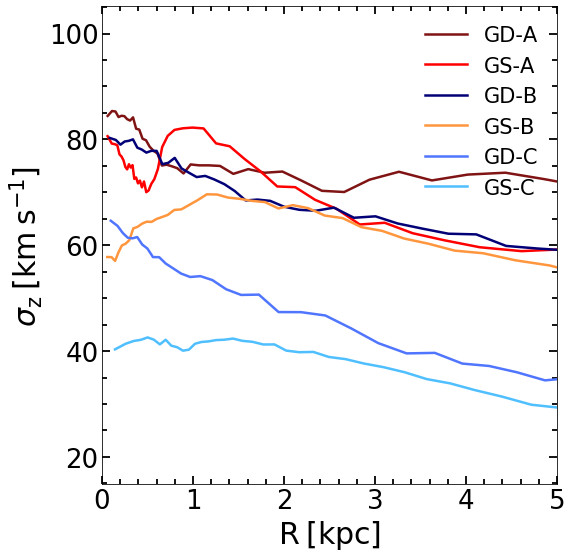

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, sigmaz_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, sigmaz_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  sigmaz_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  sigmaz_MWgs, '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, sigmaz_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, sigmaz_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')


ax.set_ylabel(r'$\sigma_{\mathrm{z}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)

# ax.set_ylim(0,0.7)
ax.set_xlim(0,5)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

## Sigma_R vs R

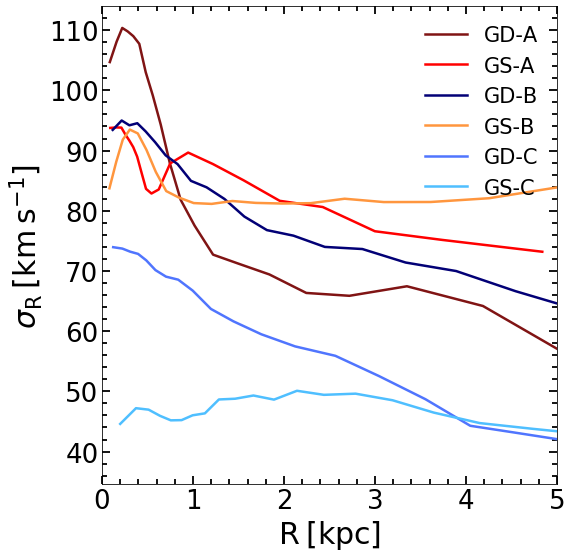

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, sigmaR_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, sigmaR_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  sigmaR_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  sigmaR_MWgs, '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, sigmaR_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, sigmaR_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'$\sigma_{\mathrm{R}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

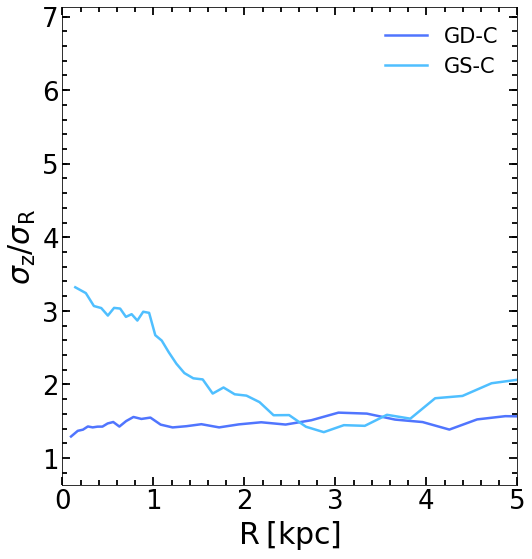

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M33gd, sigmaR_M33gd**2/sigmaz_M33gd**2,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, sigmaR_M33gd**2/sigmaz_M33gs**2,'-', lw=2.5, color='#4FBFFF', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'$\sigma_{\mathrm{z}}/\sigma_{\mathrm{R}}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

## Veloc circ


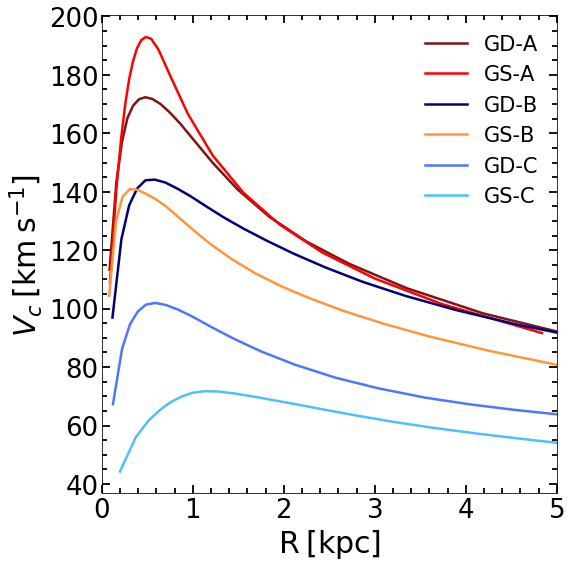

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, Vcirc_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, Vcirc_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  Vcirc_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  Vcirc_MWgs ,'-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, Vcirc_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, Vcirc_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')


ax.set_ylabel(r'$V_c \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)
# ax.set_xscale('log')
# ax.set_yscale('log')


ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

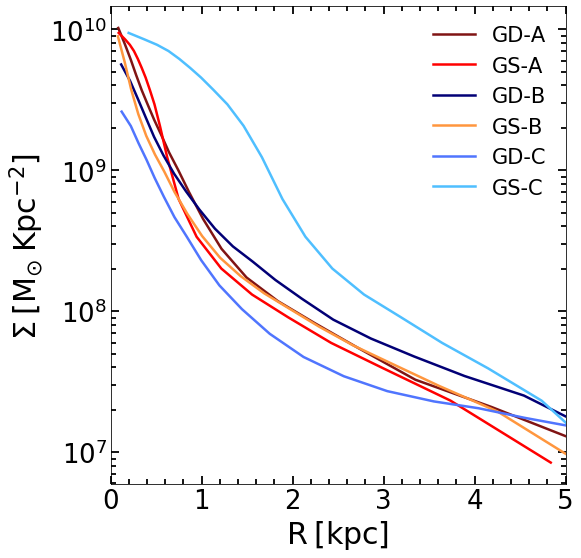

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, surden_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, surden_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  surden_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  surden_MWgs, '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, surden_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, surden_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')

ax.set_yscale('log')
ax.set_ylabel(r'$\Sigma \: \mathrm{[M_{\odot}\:Kpc^{-2}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

## Parámetro de Toomre

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q, np.sqrt(k)

In [4]:
Q_M31gd = tommre(rbin_M31gd, Vcirc_M31gd,sigmaR_M31gd,surden_M31gd)
Q_MWgd  = tommre(rbin_MWgd,  Vcirc_MWgd, sigmaR_MWgd, surden_MWgd)
Q_M33gd = tommre(rbin_M33gd, Vcirc_M33gd,sigmaR_M33gd,surden_M33gd)

Q_M31gs = tommre(rbin_M31gs, Vcirc_M31gs,sigmaR_M31gs,surden_M31gs)
Q_MWgs  = tommre(rbin_MWgs,  Vcirc_MWgs, sigmaR_MWgs, surden_MWgs)
Q_M33gs = tommre(rbin_M33gs, Vcirc_M33gs,sigmaR_M33gs,surden_M33gs)


/home/omarioni/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


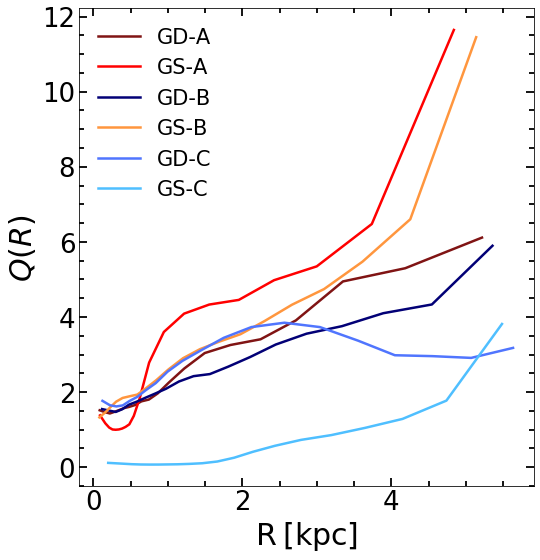

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, Q_M31gd[0],'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, Q_M31gs[0],'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  Q_MWgd[0], '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  Q_MWgs[0], '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, Q_M33gd[0],'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, Q_M33gs[0],'-', lw=2.5, color='#4FBFFF', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'$Q(R)$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
# ax.set_xlim(0,5)
# ax.set_ylim(0,5)
# ax.set_xscale('log')


ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.legend(fontsize=21,frameon=False, loc=2)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

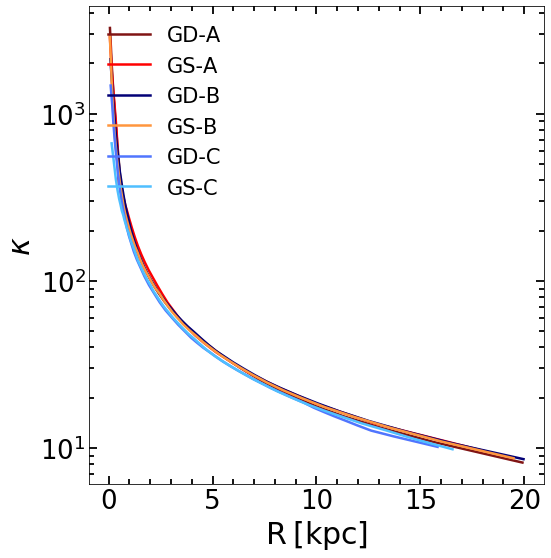

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, Q_M31gd[1],'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rbin_M31gs, Q_M31gs[1],'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rbin_MWgd,  Q_MWgd[1], '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rbin_MWgs,  Q_MWgs[1], '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rbin_M33gd, Q_M33gd[1],'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rbin_M33gs, Q_M33gs[1],'-', lw=2.5, color='#4FBFFF', label='GS-C')

ax.set_yscale('log')
ax.set_ylabel(r'$\kappa$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
# ax.set_xlim(0,5)
# ax.set_ylim(0,5)


ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.legend(fontsize=21,frameon=False, loc=2)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

In [5]:
# import h5py
# import rotation_mio as rot
# import time_conversion as tiempo

# h=0.732
# G = 4.299e-6
# a0=1
# H0 = h*100
# omega_lambda=0.716
# omega_matter=0.1277/(h**2.)
# omega0 = omega_lambda + omega_matter

# vector = ('00','01','03')
# vector3 = ('M31','MW','M33')

# path = '/home/omarioni/'
# atime = np.loadtxt(path + 'redshift_outputs.txt')
# aexp = atime[:,2]


# path = '/mnt/is2/alejandro/ornella/'

# # snapshot=range(496,50,-1)
# # for isnap in snapshot:
# #     snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

# snap = h5py.File(path+'outputs_1/snap_496.h5py', 'r')
    
# for i in range(0,3):
#     cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
#     r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

#     pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
#     mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
#     vel  = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Velocities'].value

# #     z = a0/aexp[isnap] - 1.
# #     Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
# #     time = tiempo.conv(z, h, omega_lambda, omega_matter)

# #---aca paso las coordenadas respecto al centro de la galaxia------
#     xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
#     ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
#     zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
#     r = np.sqrt(xstr**2+ystr**2+zstr**2)

#     v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
#     v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
#     v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

# #----------------------masas----------------------------
#     mstr = mstr/h

#     r200 = r200*aexp[isnap]/h

#     rgal=0.15*r200

#     limit = np.where(r < rgal)
#     r_sort = np.sort(r[limit])
#     r_indice = np.argsort(r[limit])

#     Mc_str = cumsum((mstr[limit])[r_indice])
#     M_gal = Mc_str[-1]

# #------------------ calculamos M90------------------------------------------
#     razon = Mc_str/M_gal
#     cincuenta, = np.where(razon < 0.5)

#     r50 = r_sort[cincuenta][-1]
# #         M90 = Mc_str[noventa]                

# #-------------------------------------------------------------------            
#     corte,=np.where(r<3*aexp[isnap])
#     veloc,=np.where(r<r50)

# #----------componentes de la velocidad del centro de masa------------
#     vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
#     vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
#     vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

# #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
#     vx = v_x - vxcm
#     vy = v_y - vycm
#     vz = v_z - vzcm

#     e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

#     xn = e1x*xstr + e1y*ystr + e1z*zstr
#     yn = e2x*xstr + e2y*ystr + e2z*zstr
#     zn = e3x*xstr + e3y*ystr + e3z*zstr
#     vxn = e1x*vx + e1y*vy + e1z*vz
#     vyn = e2x*vx + e2y*vy + e2z*vz
#     vzn = e3x*vx + e3y*vy + e3z*vz

# #----------calculamos las dispersiones de velocidades---------------------
#     R = np.sqrt(xn**2 + yn**2)

#     Vr = (xn*vxn + yn*vyn)/R
#     Vt = (xn*vyn - yn*vxn)/R

#     n = len(xn)-1.

#     sigma_x = np.sqrt(sum((vxn-np.mean(vxn))**2)/n)
#     sigma_y = np.sqrt(sum((vyn-np.mean(vyn))**2)/n)
#     sigma_z = np.sqrt(sum((vzn-np.mean(vzn))**2)/n)

#     sigma_R = np.sqrt(sum((Vr - np.mean(Vr))**2)/n)
#     sigma_t = np.sqrt(sum((Vt - np.mean(Vt))**2)/n)

# #         sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)

# #         C1 = sigma_z/sigma_total

# #--------------------------------------------------------------------------------------------------------------------
#     path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
#     archivo1 =  open(path2 + str('%s'%vector3[i])+'_sigma_vsR.dat','a')

#     archivo1.write(str('%12.6f'% time) +'\t'+
#                    str('%12.6f'% sigma_x) +'\t'+
#                    str('%12.6f'% sigma_y) +'\t'+
#                    str('%12.6f'% sigma_z) +'\t'+
#                    str('%12.6f'% sigma_R) +'\t'+
#                    str('%12.6f'% sigma_t) +'\n')
#     archivo1.close()     

        
    

In [6]:
import h5py
import rotation_mio as rot

a0=1

vector = (1,2,4)
vector2 = ('M31', 'MW','M33')

path = '/mnt/sersic2/omarioni/'
snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    
    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
#----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])


        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        corte,=np.where(r<3*aexp)
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])

        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        
#----------calculamos las dispersiones de velocidades---------------------
        R = np.sqrt(xn**2 + yn**2)
        
        Vr = (xn*vxn + yn*vyn)/R
        Vt = (xn*vyn - yn*vxn)/R
        
        n = len(xn)-1.
        
        sigma_x = np.sqrt(sum((vxn-np.mean(vxn))**2)/n)
        sigma_y = np.sqrt(sum((vyn-np.mean(vyn))**2)/n)
        sigma_z = np.sqrt(sum((vzn-np.mean(vzn))**2)/n)
        
        sigma_R = np.sqrt(sum((Vr - np.mean(Vr))**2)/n)
        sigma_t = np.sqrt(sum((Vt - np.mean(Vt))**2)/n)
        
#         sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
        
#         C1 = sigma_z/sigma_total
        
#--------------------------------------------------------------------------------------------------------------------
        path2 = '/home/omarioni/Barras_GdGs/Barras_Gs/_data/'
        archivo1 =  open(path2 + str('%s'%vector2[i])+'_sigma.dat','a')
        
        archivo1.write(str('%12.6f'% time) +'\t'+
                       str('%12.6f'% sigma_x) +'\t'+
                       str('%12.6f'% sigma_y) +'\t'+
                       str('%12.6f'% sigma_z) +'\t'+
                       str('%12.6f'% sigma_R) +'\t'+
                       str('%12.6f'% sigma_t) +'\n')
        archivo1.close()     

        
    

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
rotation_mio.py:5: RuntimeWarning: invalid value encountered in sqrt
  r   = np.sqrt(x**2+y**2+z**2)
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in divide


In [2]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_sigma.dat')
time_M31gd   = M31_gd[:,0]
sigmaz_M31gd = M31_gd[:,3]

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_sigma.dat')
time_MWgd   = MW_gd[:,0]
sigmaz_MWgd = MW_gd[:,3]

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_sigma.dat')
time_M33gd   = M33_gd[:,0]
sigmaz_M33gd = M33_gd[:,3]

#---------------------------------------------------------------------------------
path = '/home/omarioni/'
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_sigma.dat')
time_M31gs   = M31_gs[:,0]
sigmaz_M31gs = M31_gs[:,3]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_sigma.dat')
time_MWgs   = MW_gs[:,0]
sigmaz_MWgs = MW_gs[:,3]

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_sigma.dat')
time_M33gs   = M33_gs[:,0]
sigmaz_M33gs = M33_gs[:,3]

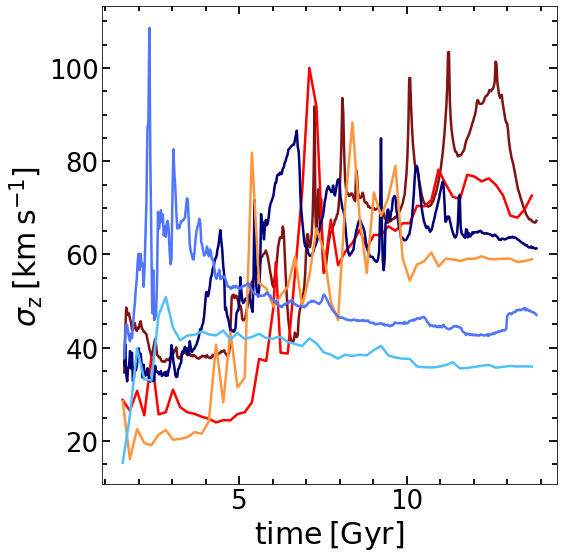

In [6]:
# import ticks

# from __future__ import unicode_literals

# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(time_M31gd, sigmaz_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(time_M31gs, sigmaz_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(time_MWgd,  sigmaz_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(time_MWgs,  sigmaz_MWgs, '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(time_M33gd, sigmaz_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(time_M33gs, sigmaz_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')


ax.set_ylabel(r'$\sigma_{\mathrm{z}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=30)

# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.set_yticklabels(['','','$0.1$','','$0.3$','','$0.5$','','$0.7$'])
# ax.axes.ticklabel_format(style='sci')
# ax.yaxis.set_minor_locator(MultipleLocator(0.025)) 

# ax.set_ylim(0,0.7)
# ax.set_xlim(0,14)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma.pdf', dpi = 100, xxbox_inches='tight')

plt.show()